# Курсовая работа выполнена Корневым Дмитрием

In [63]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config inlinebackend.figure_format = 'svg'
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate,learning_curve, StratifiedKFold,cross_val_score

In [64]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [65]:
## Познакомимся с данными. В них присутствуют пропуски и категориальные переменные

data = pd.read_csv('course_project_train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [66]:
data.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [67]:
data.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


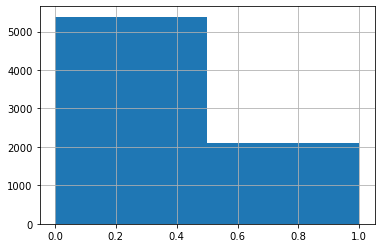

In [68]:
# Познакомимся с целевой переменной

data['Credit Default'].hist(bins=2)

In [69]:
## Доли классов 1 и 0 :

print('1: ',data['Credit Default'].sum()/len(data['Credit Default']))
print('0: ',1 - data['Credit Default'].sum()/len(data['Credit Default']))

1:  0.28173333333333334
0:  0.7182666666666666


In [70]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [71]:
## Подготовим данные

In [72]:
def prep_data(data):
    
    data_X = data.copy()
    
    ## Заполним пропуски
    
    data_X['Bankruptcies'].fillna(0, inplace=True)
    data_X['Credit Score'].fillna(data_X['Credit Score'].mode()[0], inplace=True)
    data_X['Annual Income'].fillna(data_X['Annual Income'].mean(), inplace=True)
    data_X['Bankruptcies'].fillna(0)
    
    ## Преобразуем категориальные переменные, объединяя малочисленные группы 

    data_X['Years in current job'].replace('< 1 year', '001', inplace=True)
    data_X['Years in current job']=data_X['Years in current job'].apply(lambda x:int(x[0:2]) if x==x else x)
    data_X['Years in current job'].fillna(int(data_X['Years in current job'].mean()), inplace=True)
    data_X['Home Ownership'].replace(['Have Mortgage','Home Mortgage','Rent','Own Home'],[3,3,2,1],inplace=True)
    data_X['Purpose'].replace(data_X['Purpose'].unique()[1:], 0, inplace=True)
    data_X['Purpose'].replace(data_X['Purpose'].unique()[0], 1, inplace=True)
    data_X['Tax Liens'].replace(data['Tax Liens'].unique()[1:], 1, inplace=True)
    data_X['Term'].replace(['Short Term','Long Term'], [1,10], inplace=True)
    
    ## Создадим новые переменные
    
    data_X['Bankruptcies & Problems']=data_X['Bankruptcies']+data_X['Number of Credit Problems'] # Bankruptcies & Problems
    data_X['Income for balance'] =  data_X['Annual Income']/(data_X['Current Credit Balance']+0.001) # Income for balance

    data_X['Income for debt'] =  data_X['Annual Income']/(data_X['Monthly Debt']+0.001) # Income for debt
    data_X['Income for MaxCredit'] =  data_X['Annual Income']/(data_X['Maximum Open Credit']+0.001) # Income for MaxCredit
    data_X['Score with MaxCredit'] = data_X['Credit Score']*data_X['Maximum Open Credit']
    data_X['MaxCredit for Account'] = data_X['Maximum Open Credit']/(data_X['Number of Open Accounts']+0.001)
    data_X['Term for MaxCredit'] = data_X['Term']/(data_X['Maximum Open Credit']+0.001)

    data_X['Ownership for Loan'] = data_X['Home Ownership']/(data_X['Current Loan Amount']+0.001)
    
    
    ## Удалим малоценные признаки
       
    data_X.drop(columns=['Months since last delinquent','Number of Open Accounts','Term'], inplace=True)
    data_X.drop(columns=['Tax Liens','Current Credit Balance','Bankruptcies'], inplace=True)
 
    
    return data_X


In [73]:
data_ = prep_data(data)
data_X = data_.drop(columns=['Credit Default'])
data_y = data_['Credit Default']
data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 19 columns):
Home Ownership               7500 non-null int64
Annual Income                7500 non-null float64
Years in current job         7500 non-null float64
Years of Credit History      7500 non-null float64
Maximum Open Credit          7500 non-null float64
Number of Credit Problems    7500 non-null float64
Purpose                      7500 non-null int64
Current Loan Amount          7500 non-null float64
Monthly Debt                 7500 non-null float64
Credit Score                 7500 non-null float64
Credit Default               7500 non-null int64
Bankruptcies & Problems      7500 non-null float64
Income for balance           7500 non-null float64
Income for debt              7500 non-null float64
Income for MaxCredit         7500 non-null float64
Score with MaxCredit         7500 non-null float64
MaxCredit for Account        7500 non-null float64
Term for MaxCredit           750

In [74]:
## Распределение признаков

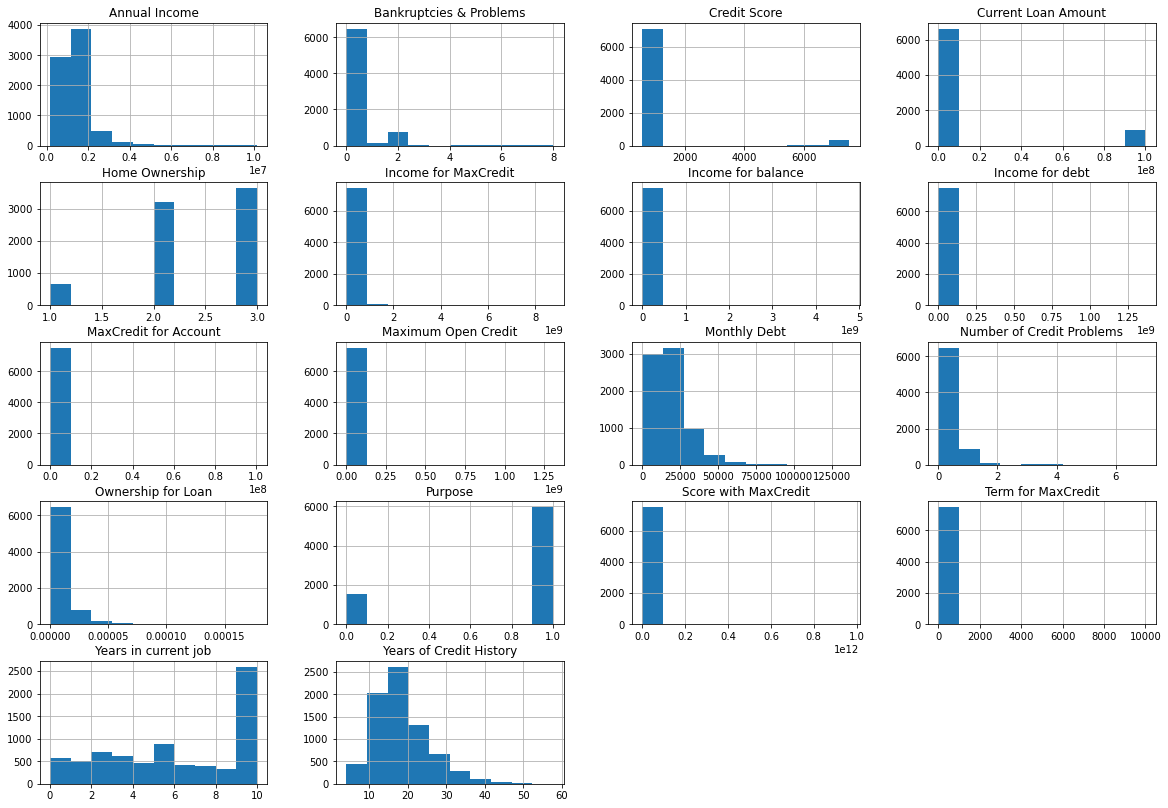

In [75]:
data_X.hist(figsize=(20,14))
plt.show()

In [76]:
## Корреляция признаков с целевым. Поскольку распределение признаков не является нормальным
## и есть категориальные переменные, используем ранговый коэффициент Кенделла

data_.corr('kendall')['Credit Default'].sort_values(ascending=False)

Credit Default               1.000000
Term for MaxCredit           0.155595
Score with MaxCredit         0.064634
Ownership for Loan           0.045674
Credit Score                 0.043901
Monthly Debt                 0.017487
Income for MaxCredit         0.012457
Number of Credit Problems    0.008094
Bankruptcies & Problems      0.007383
Years in current job        -0.004889
Purpose                     -0.015075
Years of Credit History     -0.025803
Income for balance          -0.039767
Maximum Open Credit         -0.051510
Home Ownership              -0.058426
Current Loan Amount         -0.058762
Annual Income               -0.070149
MaxCredit for Account       -0.075168
Income for debt             -0.085642
Name: Credit Default, dtype: float64

In [58]:
## Корреляция признаков носит слабовыраженный характер

In [4674]:
## В качестве классификатора выберем xgboost
## Подберем гиперпараметры

In [83]:
xgc = XGBClassifier(n_estimators=100,max_depth=9, min_child_weight=5,scale_pos_weight=2.1,gamma=0.01,learning_rate=0.01,reg_lambda=5,reg_alpha=0.03)


In [84]:
## Оценим модель на кроссвалидации на трех фолдах

In [85]:

cross_val =cross_validate(xgc, data_X,data_y,cv=3,scoring=['f1','precision','recall'],return_train_score=True)
for score, value in cross_val.items():
    print(score, value ,'\n mean:', value.mean())

fit_time [0.70710206 0.59839964 0.65524745] 
 mean: 0.6535830497741699
score_time [0.01695514 0.01695371 0.01894903] 
 mean: 0.01761929194132487
test_f1 [0.5134938  0.53069866 0.53389238] 
 mean: 0.5260282807446305
train_f1 [0.69670096 0.69032959 0.69212411] 
 mean: 0.6930515511754599
test_precision [0.52773613 0.52734923 0.5261708 ] 
 mean: 0.5270853864812017
train_precision [0.6964539  0.70488166 0.66557377] 
 mean: 0.688969776001919
test_recall [0.5        0.53409091 0.54184397] 
 mean: 0.5253116269073717
train_recall [0.69694819 0.67636622 0.72088068] 
 mean: 0.698065029733101


In [86]:
## Важность признаков
xgc.fit(data_X, data_y)
f=list(zip(xgc.feature_importances_,data_X.columns))
f.sort(reverse=True)
f

[(0.28778583, 'Credit Score'),
 (0.22055753, 'Current Loan Amount'),
 (0.126453, 'Term for MaxCredit'),
 (0.0364381, 'Annual Income'),
 (0.03533679, 'Ownership for Loan'),
 (0.033755947, 'Bankruptcies & Problems'),
 (0.028807493, 'Income for debt'),
 (0.028220482, 'Home Ownership'),
 (0.025855696, 'Score with MaxCredit'),
 (0.02326418, 'Income for MaxCredit'),
 (0.023188073, 'Income for balance'),
 (0.023040162, 'MaxCredit for Account'),
 (0.018769395, 'Monthly Debt'),
 (0.01845987, 'Maximum Open Credit'),
 (0.018287951, 'Years in current job'),
 (0.018149117, 'Years of Credit History'),
 (0.017098846, 'Number of Credit Problems'),
 (0.016531534, 'Purpose')]

In [87]:
# Прогноз

In [94]:
data_test = pd.read_csv('course_project_test.csv')
data_test_prep = prep_data(data_test)
predict = xgc.predict(data_test_prep)
pd_pred= pd.DataFrame({'Credit Default': predict},)
pd_pred.to_csv("submission.csv", index=False)